**Notebooks that inspired this work**

* https://www.kaggle.com/code/kimtaehun/eda-and-baseline-with-multiple-models
* https://www.kaggle.com/code/yaaangzhou/playground-s3-e22-eda-modeling#3.-Preprocessing-and-Features-Selections
* https://www.kaggle.com/code/arunklenin/advanced-feature-engg-techniques-beyond-basics#4.-Handle-Missing-Values

**Ideias**

* lesion_3 should be dropped (chi-square test)
* Temperature pow(2)
* get_dummies
* cleanlab
* RecursiveFeatureElimanation
* target encoding
* build different models and ensemble

In [1]:
import pandas as pd
import xgboost as xg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

import time
from xgboost import XGBClassifier
%matplotlib inline
tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
train = pd.read_csv('playground-series-s3e22/train.csv')
original = pd.read_csv("horse.csv")

### EDA

In [ ]:
train.head(15)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
5,5,no,adult,529642,38.1,56.0,32.0,normal,normal,bright_pink,...,49.0,8.0,cloudy,2.8,no,0,0,0,yes,lived
6,6,yes,adult,534787,38.3,36.0,16.0,cool,reduced,normal_pink,...,43.0,75.0,cloudy,1.0,no,3111,0,0,yes,euthanized
7,7,no,adult,529461,39.2,114.0,24.0,cool,reduced,pale_cyanotic,...,57.0,7.6,serosanguious,4.5,yes,2207,0,0,yes,died
8,8,no,adult,528742,37.4,48.0,12.0,cool,reduced,normal_pink,...,40.0,7.8,cloudy,2.6,no,0,0,0,yes,lived
9,9,yes,adult,529640,38.3,129.0,48.0,cool,reduced,pale_pink,...,57.0,4.9,cloudy,2.9,yes,3209,0,0,yes,died


In [ ]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
summary(train).style.background_gradient(cmap='YlOrBr')

data shape: (1235, 29)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
id,int64,0,0.000000,1235,0.000000,1234.000000,617.000000,356.658100,0,1,2
surgery,object,0,0.000000,2,nan,nan,nan,nan,yes,yes,yes
age,object,0,0.000000,2,nan,nan,nan,nan,adult,adult,adult
hospital_number,int64,0,0.000000,255,521399.000000,5305129.000000,954500.401619,1356403.138940,530001,533836,529812
rectal_temp,float64,0,0.000000,43,35.400000,40.800000,38.202186,0.788668,38.100000,37.500000,38.300000
pulse,float64,0,0.000000,50,30.000000,184.000000,79.574089,29.108638,132.000000,88.000000,120.000000
respiratory_rate,float64,0,0.000000,37,8.000000,96.000000,30.054251,16.452066,24.000000,12.000000,28.000000
temp_of_extremities,object,0,0.000000,5,nan,nan,nan,nan,cool,cool,cool
peripheral_pulse,object,0,0.000000,5,nan,nan,nan,nan,reduced,normal,reduced
mucous_membrane,object,0,0.000000,7,nan,nan,nan,nan,dark_cyanotic,pale_cyanotic,pale_pink


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 About Dataset:</font></h3>

<ul>
    <li><b>Objective</b>: The dataset aims to predict whether a horse can survive based on past medical conditions.</li>
    <li><b>Outcome</b>: Noted by the "outcome" variable. Possibilities include: lived, died, was euthanized.</li>
    <li><b>Missing Values</b>: The dataset contains a significant number of NA values, emphasizing the importance of data imputation in the preprocessing steps.</li>
    <li><b>Attributes</b>: The dataset provides a mix of categorical and linear (numeric) variables, covering a variety of clinical measurements, subjective judgments, and explicit medical findings. In total, there are 28 attributes to consider, with the 'outcome' being the target variable.</li>
    <li><b>Special Notes</b>: Some attributes, such as 'pain', should not be treated as ordered or discrete. Others, like 'type of lesion', break down into several sub-categories.</li>
    <li><b>Contextual Information</b>: Certain parameters, like 'rectal temperature' and 'pulse', offer specific context into the condition of the horse, such as potential infections or shock.</li>
    <li><b>Significant Attributes</b>: Parameters like 'abdominal distension' and 'nasogastric reflux' provide crucial indications about the horse's health and potential need for surgical interventions.</li>
</ul>

This summary offers a detailed initial understanding of the dataset's characteristics, assisting in making informed decisions in the subsequent analysis and modeling steps.
</div>


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Dataset Attributes Description:</font></h3>

<table border="1" cellpadding="5" cellspacing="0">
    <thead>
        <tr>
            <th>Attribute</th>
            <th>Description</th>
            <th>Values</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>surgery?</td>
            <td>Whether the horse had surgery</td>
            <td>1 = Yes, 2 = No</td>
        </tr>
        <tr>
            <td>Age</td>
            <td>Age category of the horse</td>
            <td>1 = Adult, 2 = Young (&lt; 6 months)</td>
        </tr>
        <tr>
            <td>Hospital Number</td>
            <td>Case number assigned to the horse</td>
            <td>Numeric ID</td>
        </tr>
        <tr>
            <td>rectal temperature</td>
            <td>Temperature in degrees celsius</td>
            <td>Linear</td>
        </tr>
        <tr>
            <td>pulse</td>
            <td>Heart rate in beats per minute</td>
            <td>Linear</td>
        </tr>
        <tr>
            <td>respiratory rate</td>
            <td>Rate of respiration</td>
            <td>Linear</td>
        </tr>
        <tr>
            <td>temperature of extremities</td>
            <td>Indication of peripheral circulation</td>
            <td>1 = Normal, 2 = Warm, 3 = Cool, 4 = Cold</td>
        </tr>
        <tr>
            <td>peripheral pulse</td>
            <td>Subjective assessment of peripheral pulse</td>
            <td>1 = Normal, 2 = Increased, 3 = Reduced, 4 = Absent</td>
        </tr>
        <tr>
            <td>mucous membranes</td>
            <td>Measurement of color of mucous membranes</td>
            <td>1-6 as described in the given data</td>
        </tr>
        <tr>
            <td>capillary refill time</td>
            <td>Clinical judgment of capillary refill time</td>
            <td>1 = &lt; 3 seconds, 2 = &gt;= 3 seconds</td>
        </tr>
        <!-- ... Rest of the rows for each attribute ... -->
        <tr>
            <td>abdominocentesis appearance</td>
            <td>Appearance of fluid from abdominocentesis</td>
            <td>1 = Clear, 2 = Cloudy, 3 = Serosanguinous</td>
        </tr>
        <tr>
            <td>abdomcentesis total protein</td>
            <td>Total protein from abdominocentesis</td>
            <td>Linear (gms/dL)</td>
        </tr>
        <tr>
            <td>outcome</td>
            <td>Final outcome for the horse</td>
            <td>1 = Lived, 2 = Died, 3 = Euthanized</td>
        </tr>
        <tr>
            <td>surgical lesion?</td>
            <td>If the lesion was surgical</td>
            <td>1 = Yes, 2 = No</td>
        </tr>
        <tr>
            <td>type of lesion</td>
            <td>Type of lesion identified</td>
            <td>Comprehensive description given (Multiple layers)</td>
        </tr>
        <tr>
            <td>cp_data</td>
            <td>Presence of pathology data for the case</td>
            <td>1 = Yes, 2 = No</td>
        </tr>
    </tbody>
</table>

</div>



> ### 📊 Target variable distribution

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.concat([train, original], ignore_index = True)

def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
    # Set background color
    plt.rcParams['figure.facecolor'] = '#FFFAF0'
    
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.2)

    s1 = df[col].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = ['#9E3F00', '#eb5e00', '#ff781f']
    inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90, frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size': 13, 
        'weight': 'bold', 
        'color': 'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = s1.index.tolist()
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='YlOrBr_r', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name}', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

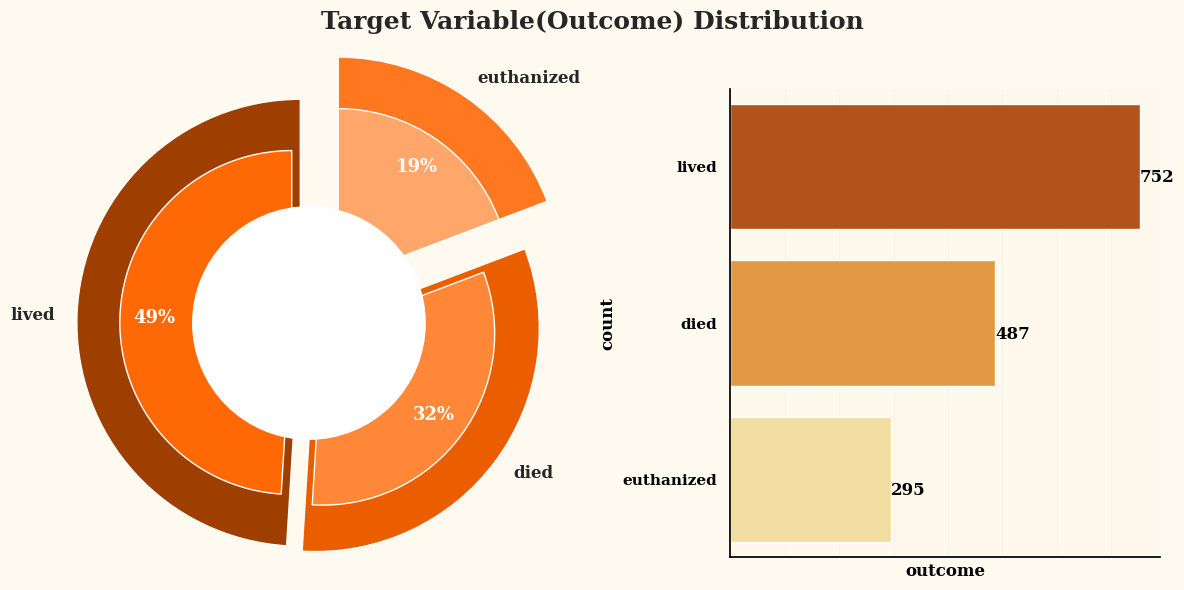

In [ ]:
plot_count(df, 'outcome', 'Target Variable(Outcome) Distribution')

In [ ]:
# Unique value counts for each column
unique_counts = train.nunique()

# Threshold to distinguish continuous and categorical
threshold = 10

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'outcome' from categorical since it's our target variable
if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

> ### 📊 Variables distribution

**Continuos_vars**

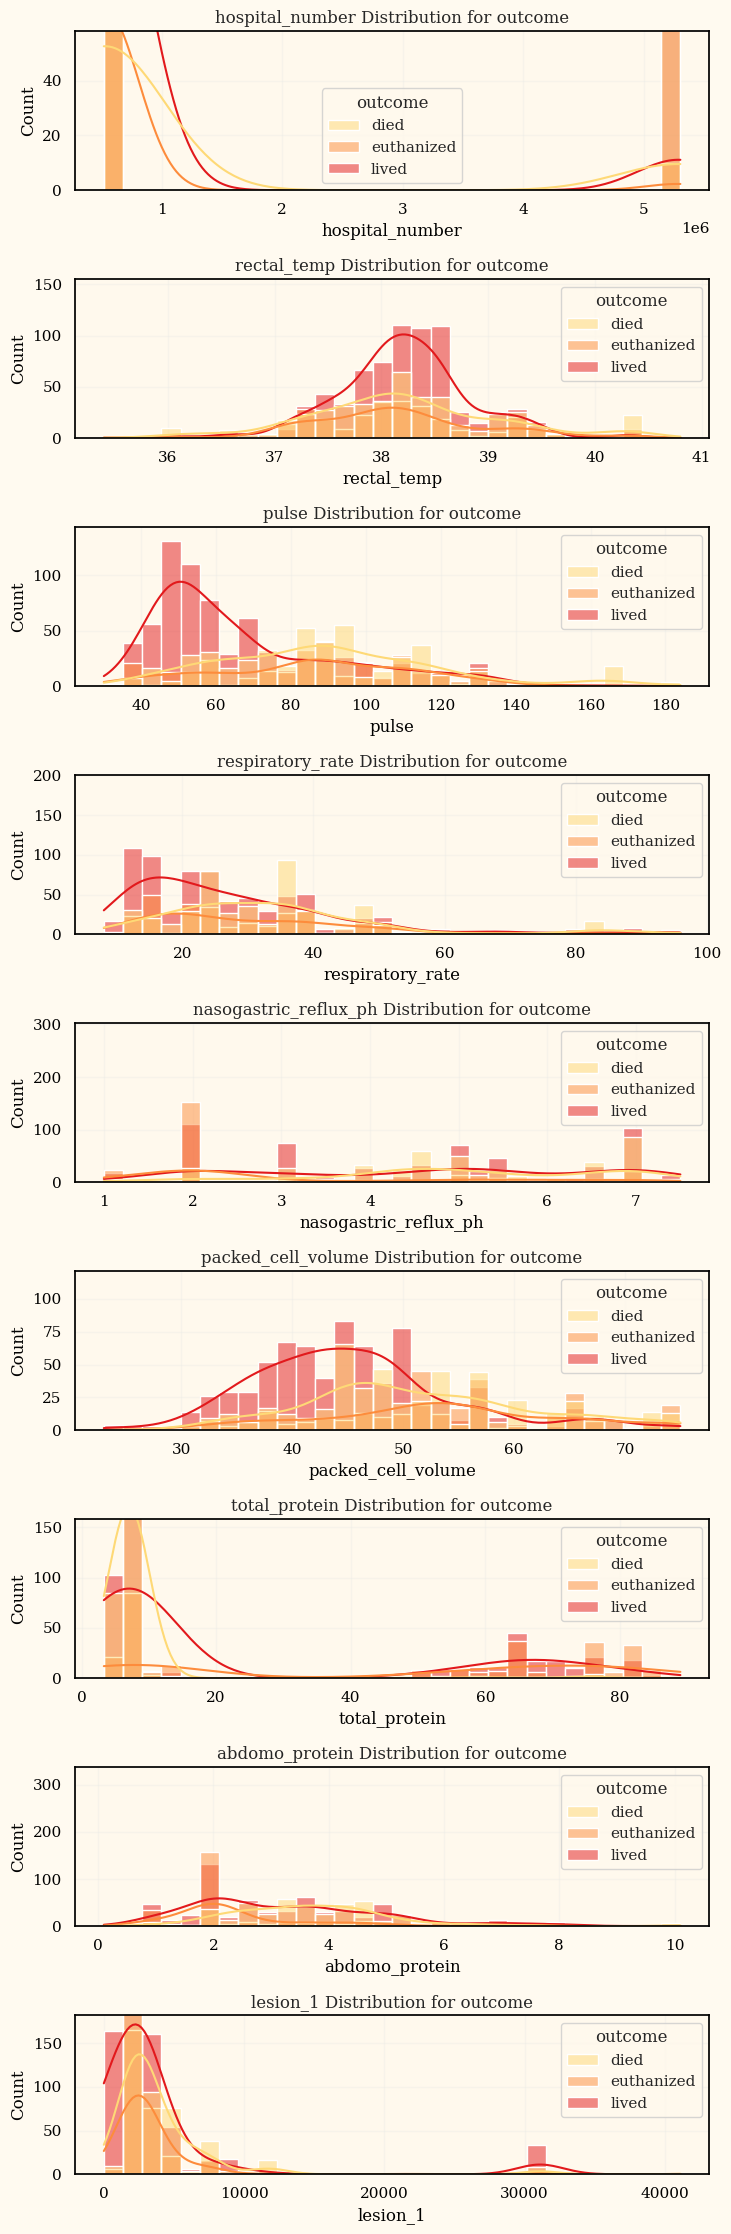

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, len(continuous_vars) * 2.5))

for idx, column in enumerate(continuous_vars):
    # Plotting for outcome
    plt.subplot(len(continuous_vars), 2, idx*2+1)
    sns.histplot(x=column, hue="outcome", data=df, bins=30, kde=True, palette='YlOrRd')
    plt.title(f"{column} Distribution for outcome")
    plt.ylim(0, df[column].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

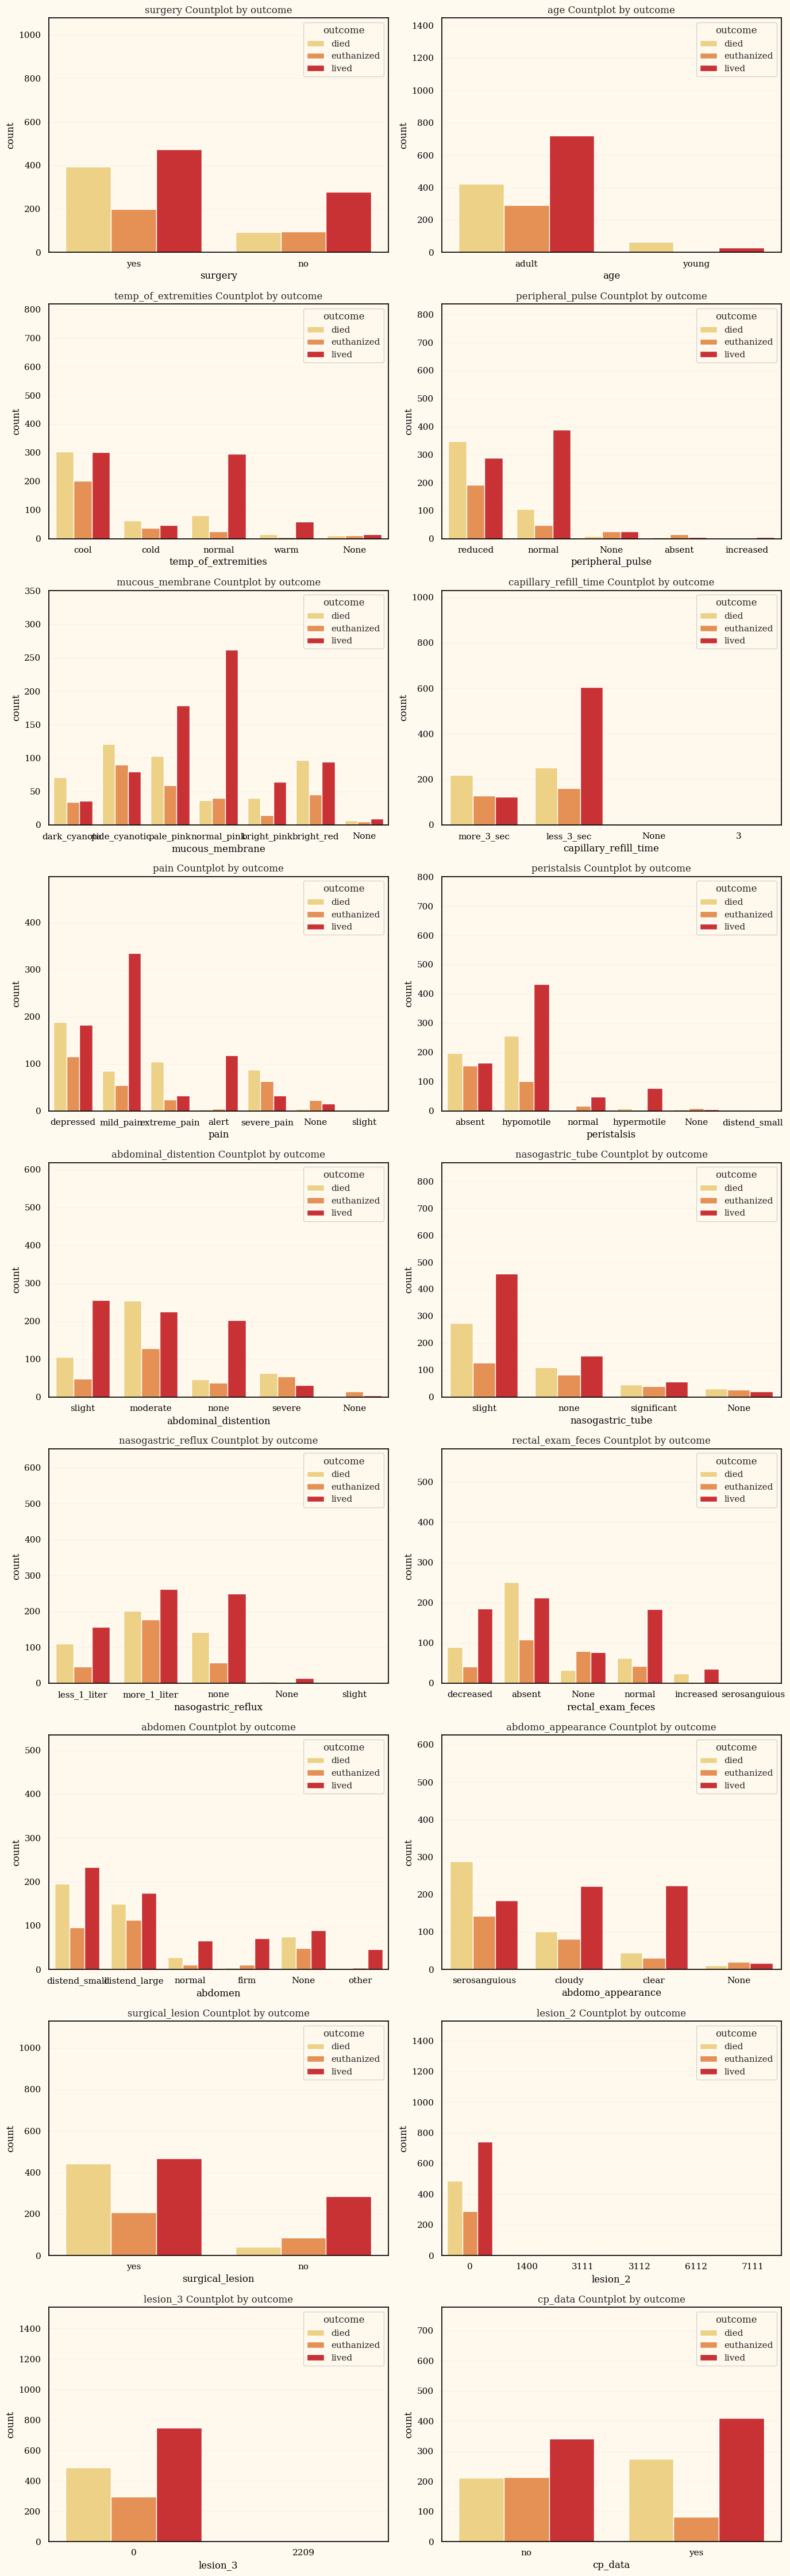

In [ ]:
plt.figure(figsize=(14, len(categorical_vars)*2.5))

for idx, column in enumerate(categorical_vars):
    plt.subplot(len(categorical_vars)//2 + len(categorical_vars) % 2, 2, idx+1)
    sns.countplot(x=column, hue="outcome", data=df, palette='YlOrRd')
    plt.title(f"{column} Countplot by outcome")
    plt.ylim(0, df[column].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Recommendations on Variables:</font></h3>
    
* A plethora of variables seem to manifest a substantial distinctive power in the dataset. However, the untreated missing values can obscure their true potential or influence. Addressing these missing values is of paramount importance for an accurate assessment and leveraging of these variables.

* Special attention should be paid to variables like 'lesion'. A meticulous preprocessing approach for such variables can not only enhance their utility but also prevent potential pitfalls or biases in the model's predictions.

</div>

**Preprocessing**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming these are your categorical variables
categorical_vars = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 
                    'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 
                    'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
                    'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 
                    'cp_data']

def encode(df, cat_cols):

    df_encoded = df.copy()
    
    # Label encode categorical columns
    label_encoders = {}
    
    for column in cat_cols:
        le = LabelEncoder()
        df_encoded[column] = le.fit_transform(df[column])
        label_encoders[column] = le
        
    return df_encoded, label_encoders

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 About Dataset:</font></h3>

<ul>
    Using label encoding to calculate the correlation for categorical variables has some caveats:
    <li><b>Arbitrary Ordering: </b> Label encoding assigns arbitrary numeric values to categorical data. These numbers might not have any inherent relationship with the original meaning of the data. Hence, when interpreting the correlation coefficient, this must be taken into account.</li>
    <li><b>Interpreting Correlation: </b> The correlation among label-encoded categorical variables might not accurately reflect the actual relationships between the variables. Especially if the order of the labels does not align with the true meaning of the data, caution in interpretation is required.</li>
    <li><b>Alternative Methods: </b>There are other statistical methods or techniques (e.g., Chi-squared test) that can be used to understand relationships between categorical data.</li>
   
</ul>

In summary, caution is needed when interpreting the correlation of label-encoded categorical variables. This approach might not represent the true relationship in the data, so it's better used as a reference in data exploration or preprocessing rather than for direct interpretation.
</div>

**feature engineering**

In [ ]:
target = 'outcome'

def process_data(df):
    
    #deleting any rows with missing more than 10 missing values per row
    missing_values_per_row = df.isna().sum(axis=1)
    print(df.shape)
    threshold = 7
    df = df[missing_values_per_row <= threshold]
    print(df.shape)
    df=df.reset_index(drop=True)
    
    for col in categorical_vars:
        df[col] = df[col].fillna(df[col].mode()[0])

    for col in continuous_vars:
        df[col] = df[col].fillna(df[col].median())
    
    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
    
    df['temp_of_extremities_status']=df['temp_of_extremities'].apply(lambda x:1 if x=='normal' else 0)
    df['rectal_temp_status']=df['rectal_temp'].apply(lambda x:1 if 37.5<=x<=38.6 else 0)
    df['temp_status']=np.where((df['temp_of_extremities_status']==1)&(df['rectal_temp_status']==1),1,0)
        
    
    features = df.drop(columns=['id', 'lesion_3']).columns.tolist()
    df_x = df[features]
    
    df_encoded, label_encoders = encode(df_x, categorical_vars)
    
    return df_encoded, features, label_encoders

In [ ]:
data_processed, all_features, labels = process_data(df)
all_features.remove('outcome')

le = LabelEncoder()
data_processed['outcome'] = le.fit_transform(data_processed['outcome'])

(1534, 29)
(1457, 29)


**Modeling**

In [ ]:
all_features

['surgery',
 'age',
 'hospital_number',
 'rectal_temp',
 'pulse',
 'respiratory_rate',
 'temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'nasogastric_reflux_ph',
 'rectal_exam_feces',
 'abdomen',
 'packed_cell_volume',
 'total_protein',
 'abdomo_appearance',
 'abdomo_protein',
 'surgical_lesion',
 'lesion_1',
 'lesion_2',
 'cp_data',
 'temp_of_extremities_status',
 'rectal_temp_status',
 'temp_status']

In [ ]:
X = data_processed[all_features]
y = data_processed[target]

In [ ]:
from sklearn.model_selection import cross_val_score

def eval_model(model, vars, target, scoring='f1_micro', folds=7):
    
    cv_scores = cross_val_score(model,vars,target,scoring=scoring,cv=folds)
    scores = np.mean(cv_scores)
    
    return scores

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

xgb_md = XGBClassifier(objective='multi:softmax', num_class=3, )
lgb_md = LGBMClassifier(objective = 'multiclass')
cat_md = CatBoostClassifier(loss_function='MultiClass', eval_metric='TotalF1:average=Macro', verbose=0)
hist_md = HistGradientBoostingClassifier(loss='categorical_crossentropy')
gbc_md = GradientBoostingClassifier()

models = {
    'xgb': xgb_md,
    'lgb': lgb_md,
    'cat': cat_md,
    'hist': hist_md,
    'gbc': gbc_md,
}

models_score = {}

# test models
for model_name, model in models.items():
    print(f'\033[1;34mTraining {model_name} models\033[0m')  # Blue for model names
    
    score = eval_model(model, X, y)
    models_score[model_name] = score
    
    print(f'\033[1;32mMean score: {score}\033[0m')  # Green for scores


Training xgb models
Mean score: 0.7323466007676532
Training lgb models
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 1248, number of used features: 28
[LightGBM] [Info] Start training from score -1.142846
[LightGBM] [Info] Start training from score -1.636236
[LightGBM] [Info] Start training from score -0.720769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1249, number of used features: 28
[LightGBM] [Info] Start training from score -1.143647
[LightGBM] [Info] Start training from score -1.637037
[LightGBM] [Info] Start training from score -0.719924
[LightGBM] [Info] Auto-choosing

**Optuna Time my dear**

In [ ]:
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback

In [ ]:
def objective(trial):


    param = {
            
        'objective':'multi:softmax',
        'num_class': 3,
        'lambda': trial.suggest_loguniform("lambda", 1e-8, 2.0),
        'alpha': trial.suggest_loguniform("alpha", 1e-8, 2.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0, 1),
        'subsample': trial.suggest_uniform('subsample', 0, 1),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.008, 0.95),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 40),
        'min_child_weight': trial.suggest_loguniform('min_child_weight',1e-10, 1e10),

        }
    
    
    
    model = XGBClassifier(**param)
    score = eval_model(model, X, y, folds=9)
    
    return score


study = create_study(direction='maximize')
study.optimize(objective, n_trials=2000)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-09-19 22:01:44,933] A new study created in memory with name: no-name-f69419bc-a0f4-428a-8586-437f83395553
[I 2023-09-19 22:01:45,266] Trial 0 finished with value: 0.319147304654551 and parameters: {'lambda': 3.591923091986592e-08, 'alpha': 0.0010842342217354376, 'colsample_bytree': 0.5229128839125162, 'subsample': 0.057845033225073395, 'learning_rate': 0.36386708249547006, 'num_boost_round': 690, 'max_depth': 10, 'min_child_weight': 401183573.71049947}. Best is trial 0 with value: 0.319147304654551.
[I 2023-09-19 22:01:46,915] Trial 1 finished with value: 0.6313932980599647 and parameters: {'lambda': 0.0037946131906024293, 'alpha': 2.026226212496831e-06, 'colsample_bytree': 0.6506345063887226, 'subsample': 0.45060055676979693, 'learning_rate': 0.524385043027987, 'num_boost_round': 528, 'max_depth': 36, 'min_child_weight': 1.270773424343633e-05}. Best is trial 1 with value: 0.6313932980599647.
[I 2023-09-19 22:01:47,216] Trial 2 finished with value: 0.319147304654551 and paramet

**Submission**

In [ ]:
tuned_params = study.best_trial.params

model = XGBClassifier(**tuned_params)#best model so far
print(eval_model(model, X, y, folds=9))
model.fit(X,y)

In [ ]:
result = pd.read_csv("playground-series-s3e22/sample_submission.csv")
test = pd.read_csv("playground-series-s3e22/test.csv")

display(test)

In [ ]:
test_processed, all_test_features, test_labels = process_data(test)

pred = model.predict(test_processed)
pred = le.inverse_transform(pred)
result['outcome'] = pred
result.to_csv('xgb-tuned3-_submission.csv', index=False)

In [ ]:
result

> ### 📊 evaluation and feature importance

In [ ]:
# #code for evaulation and comparision + feature importance for each models.

# for model_name, model_dict in best_models.items():
#     for target in target_cols:
#         print(f'\033[1;34;4mVisualization for {model_name} {target}\033[0m')  # Blue with underline for model and target
        
#         best_val_preds = model_dict[target].predict(df[features])
#         f1 = f1_score(df[target], best_val_preds, average='micro')
#         print(f'\033[1;35mMicro-averaged F1-Score: {f1:.5f}\033[0m')  # Purple for F1 scores

#         # Confusion Matrix Visualization
#         show_confusion(best_val_preds, df[target])

#         # Feature Importance Visualization
#         f_imp_df = pd.DataFrame({'feature': features, 'avg_imp': model_dict[target].feature_importances_})
#         f_importance_plot(f_imp_df)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title('Feature importances', size=16, y=1.05, 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='YlOrBr_r', linestyle="-", 
                    linewidth=0.5, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion(y_pred, y_true):
    # Assuming y_true and y_pred are numpy arrays
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Conclusions:</font></h3>

* This dataset warrants a thorough preprocessing approach for significant improvements. However, for illustrative purposes, I carried out a very basic preprocessing. This has likely contributed to the less-than-ideal micro-averaged F1 scores observed.

* The models were not subjected to hyperparameter tuning, which offers another avenue for substantial enhancements in performance.

* I would encourage further exploration and refinement, particularly in areas such as handling missing values, creating new derived features, and diving deeper into the data's intricacies. Building upon these insights could lead to model improvements and better predictive performance.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.10)  # 0.1 indicates 99% of observations approximately

sel.fit(X)  # fit finds the features with low variance

In [ ]:
sum(sel.get_support())

In [ ]:
from xgboost import plot_importance

plot_importance(model)

In [ ]:
plt.figure(figsize=(25, 25))

dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, fmt='.2g')